In [1]:
# ============================================================================
# PART 1: INSTALLATION & SETUP
# ============================================================================


print("Installing packages...")
import subprocess, sys

subprocess.check_call([
    sys.executable, "-m", "pip", "install", "-q",
    "seaborn",
])
print("Installed\n")

Installing packages...



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /anaconda/envs/azureml_py310_sdkv2/bin/python -m pip install --upgrade pip


    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  3.0     145.0  233.0  1.0      0.0    150.0    0.0      2.3   
1  37.0  1.0  2.0     130.0  250.0  0.0      1.0    187.0    0.0      3.5   
2  41.0  0.0  1.0     130.0  204.0  0.0      0.0    172.0    0.0      1.4   
3  56.0  1.0  1.0     120.0  236.0  0.0      1.0    178.0    0.0      0.8   
4  57.0  0.0  0.0     120.0  354.0  0.0      1.0    163.0    1.0      0.6   

   slope   ca  thal  target  
0    0.0  0.0   1.0     1.0  
1    0.0  0.0   2.0     1.0  
2    2.0  0.0   2.0     1.0  
3    2.0  0.0   2.0     1.0  
4    2.0  0.0   2.0     1.0  
Numerical: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Categorical: []


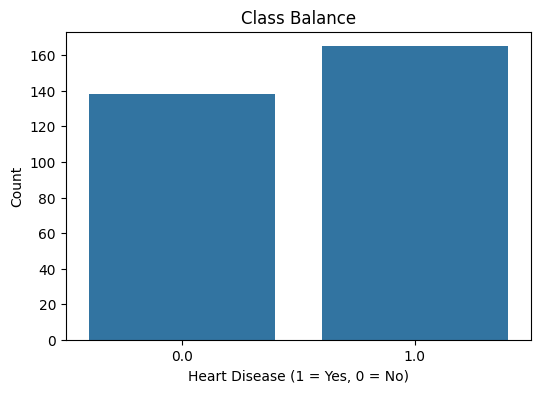

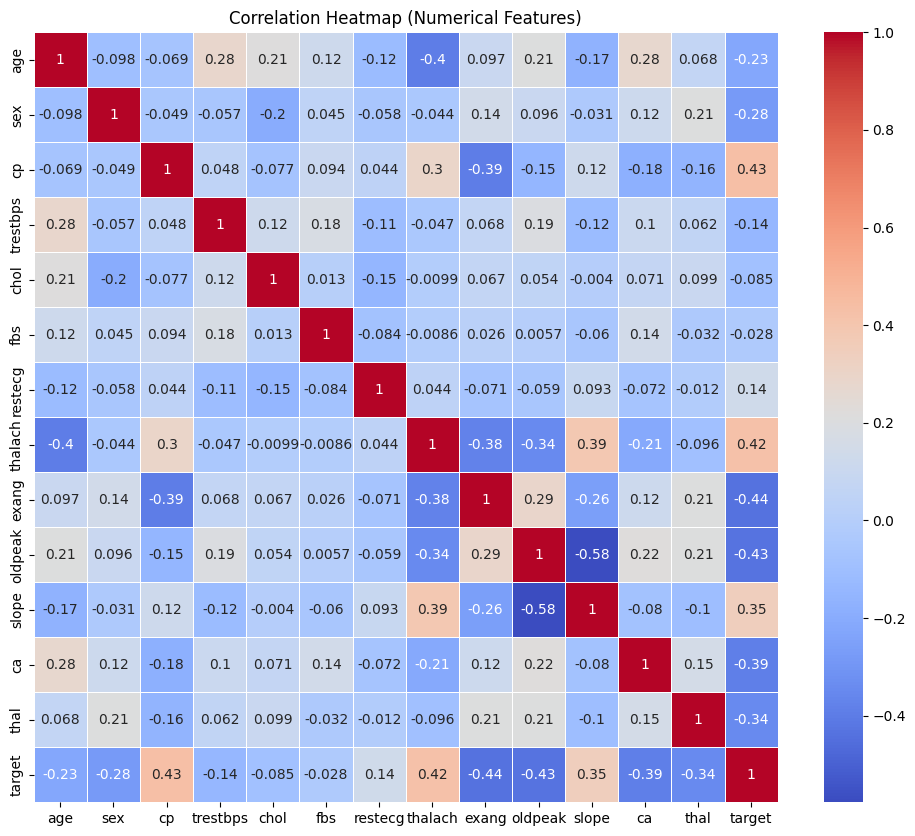

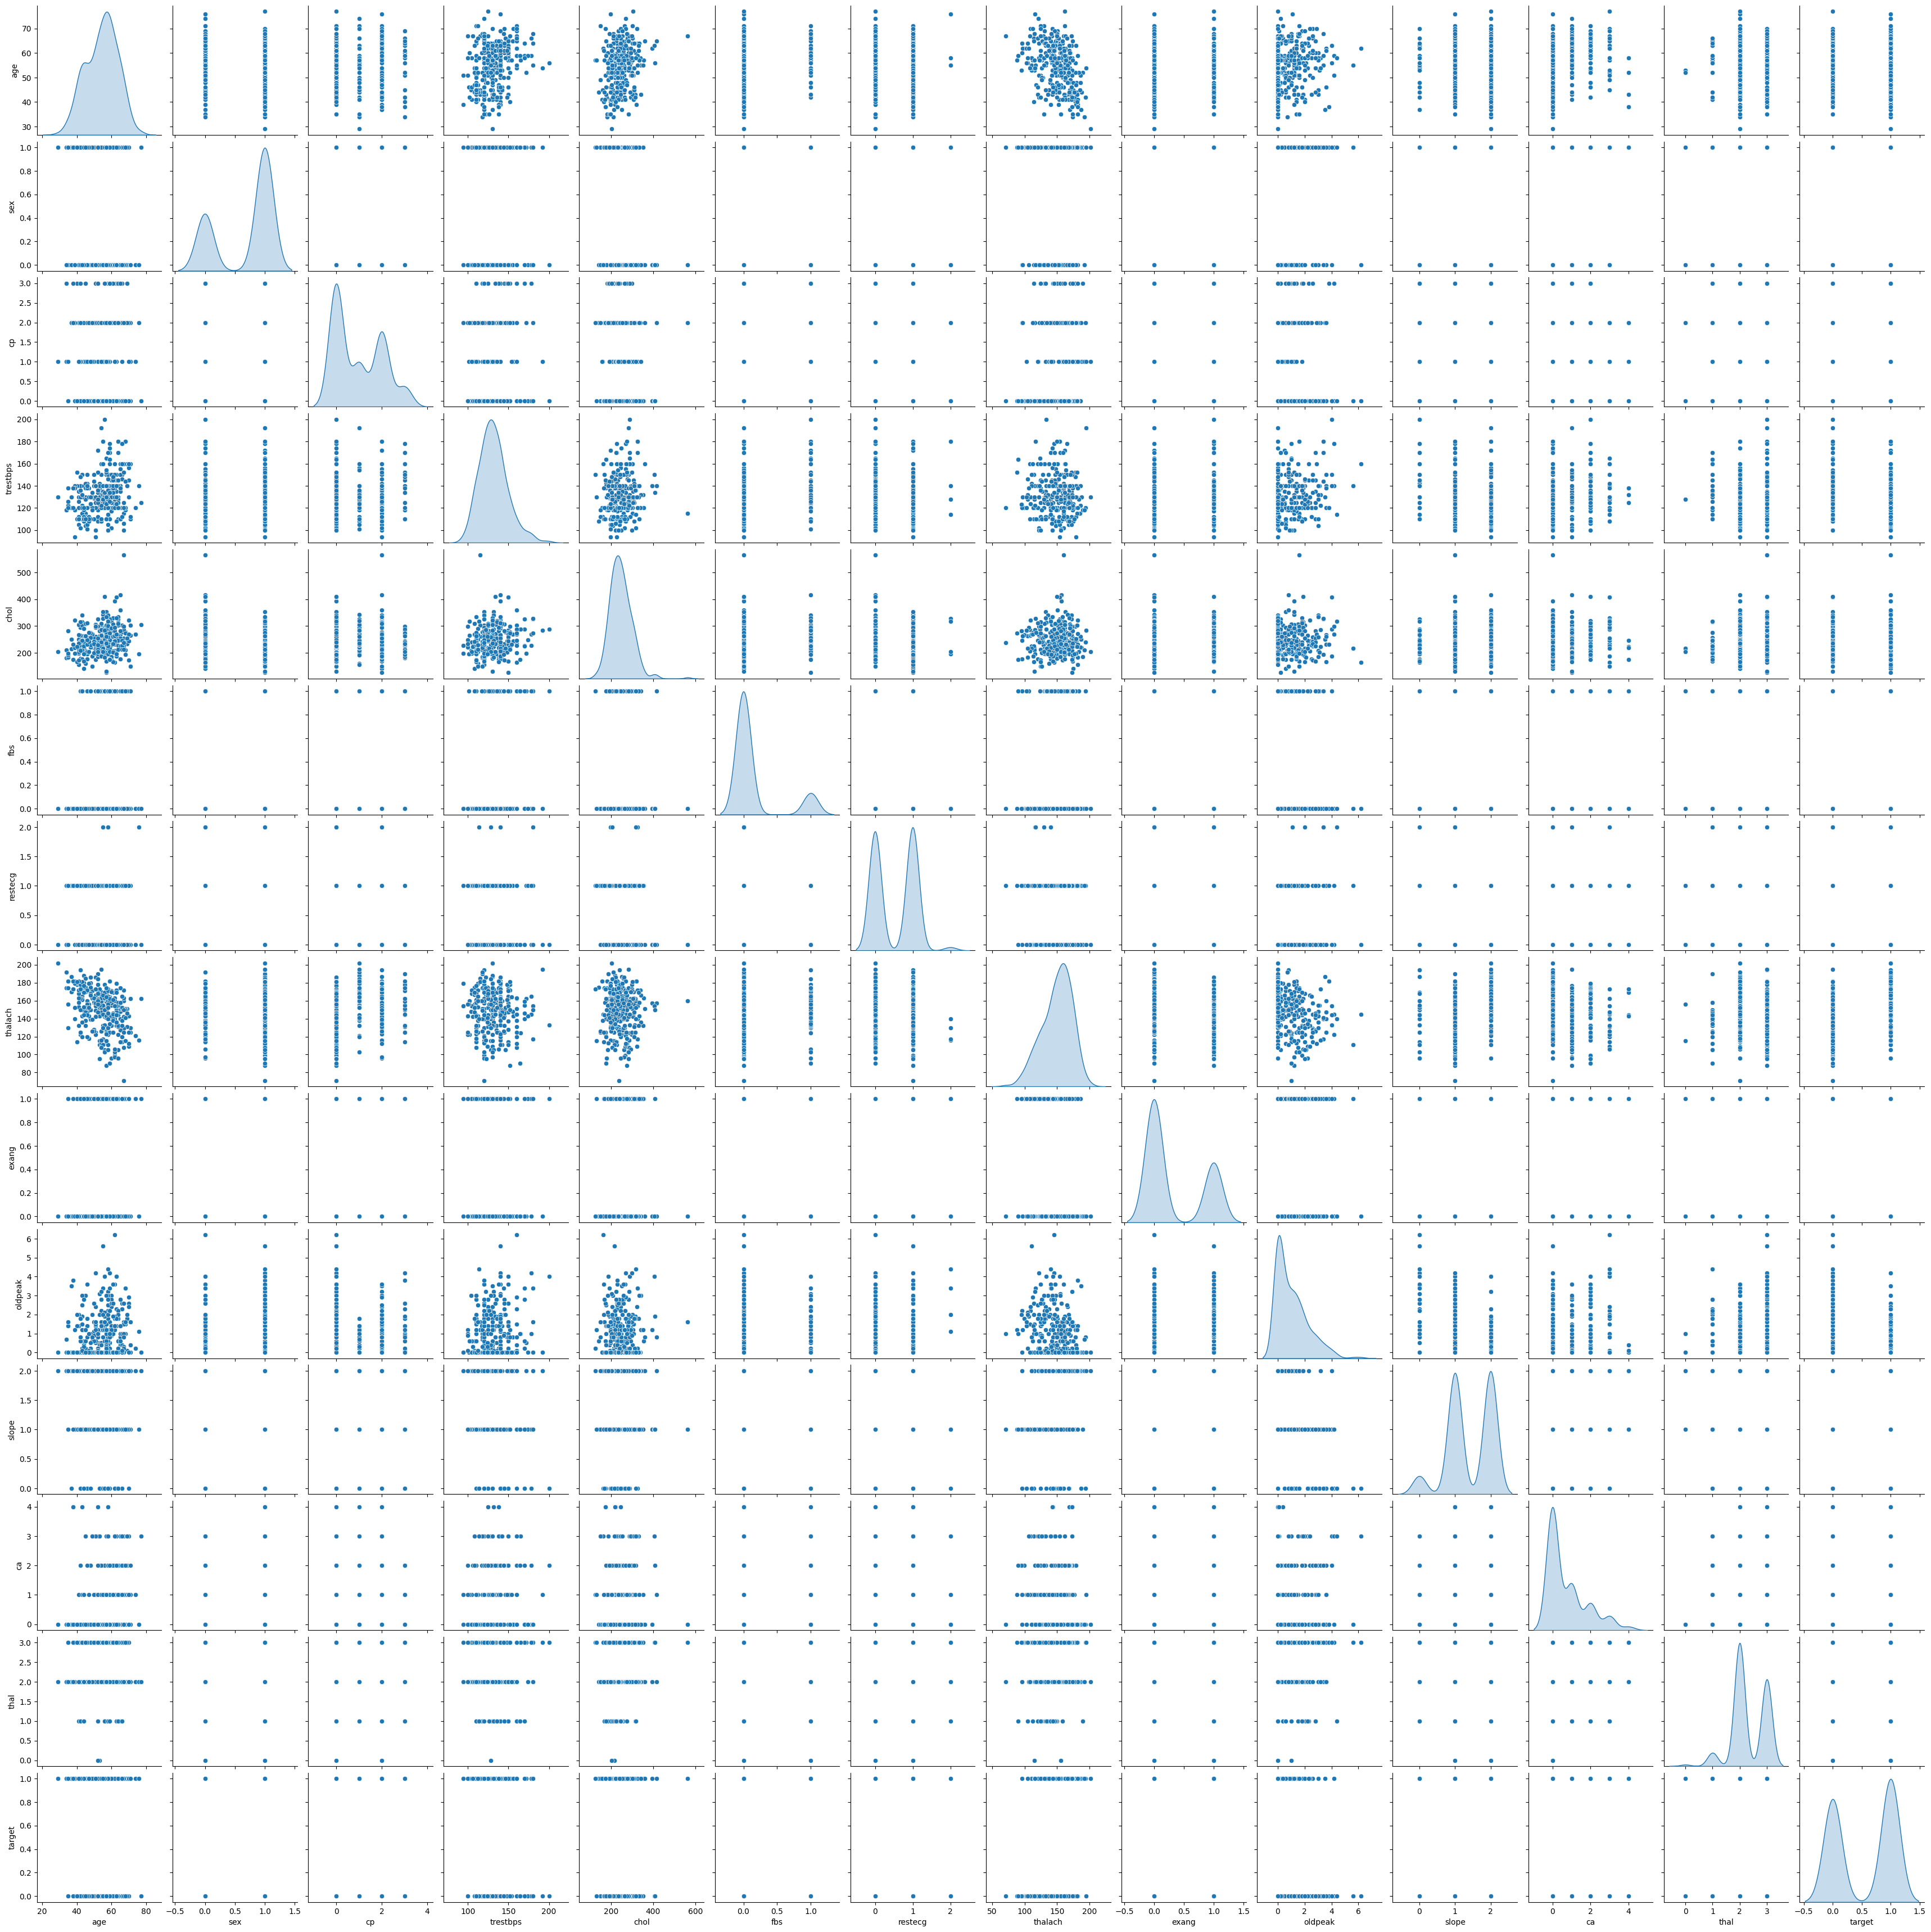

Shape: (303, 14)
Missing values after preprocessing: 0
Saved cleaned dataset as heart_cleaned.csv
/mnt/batch/tasks/shared/LS_root/mounts/clusters/ag-aiml-compute/code/Users/v_2agho/heart-mlops-azure/data/processed/heart_cleaned.csv


In [44]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from pathlib import Path
import pandas as pd

base_dir = Path.cwd().parent
raw_path = base_dir / "data" / "raw" / "heart.csv"
processed_path = base_dir / "data" / "processed" / "heart_cleaned.csv"

# Read the file
df = pd.read_csv(raw_path)

print(df.head())


#seperate numerical and categorical data

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical:", num_cols)
print("Categorical:", cat_cols)

#clean and preprocess, handle missing data
#- Numerical → impute with median + scale
#- Categorical → impute with most frequent + one‑hot encode

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)
X_processed = preprocessor.fit_transform(df)

#Class imbalance
plt.figure(figsize=(6,4))
sns.countplot(x=df['target'])
plt.title("Class Balance")
plt.xlabel("Heart Disease (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

#Hist for numerical features
plt.figure(figsize=(12, 10))
corr = df[num_cols].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

sns.pairplot(df[num_cols], diag_kind="kde")
plt.show()

print("Shape:", df.shape)
print("Missing values after preprocessing:", df.isna().sum().sum())

df.to_csv(processed_path, index=False)
print("Saved cleaned dataset as heart_cleaned.csv")
print(processed_path)

#### Training and Tracking

In [42]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [45]:


df = pd.read_csv(processed_path)

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1.0


## Train/Test Split

In [46]:
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Preprocessing Pipeline

In [47]:
numeric_features = X.select_dtypes(include=np.number).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ]
)

## Train a Baseline Model (Logistic Regression)

In [48]:
logreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

logreg_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [49]:
y_pred = logreg_model.predict(X_test)
y_prob = logreg_model.predict_proba(X_test)[:, 1]

lr_acc = accuracy_score(y_test, y_pred)
lr_auc = roc_auc_score(y_test, y_prob)

print("Logical regression Accuracy:", lr_acc)
print("Logical regression AUC:", lr_auc)

Logical regression Accuracy: 0.8032786885245902
Logical regression AUC: 0.8690476190476191


## Random Forest Model

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_prob_rf)

print("Random Forest Accuracy:", rf_acc)
print("Random Forest AUC:", rf_auc)

Random Forest Accuracy: 0.8360655737704918
Random Forest AUC: 0.9155844155844156


In [51]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [lr_acc, rf_acc],
    "AUC": [lr_auc, rf_auc]
})

results

,Model,Accuracy,AUC
0,Logistic Regression,0.803279,0.869048
1,Random Forest,0.836066,0.915584


In [52]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("heart-disease-local")

# Logistic Regression
with mlflow.start_run(run_name="logreg"):
    mlflow.log_metric("accuracy", lr_acc)
    mlflow.log_metric("auc", lr_auc)
    mlflow.sklearn.log_model(logreg_model, artifact_path="logreg_model")

# Random Forest
with mlflow.start_run(run_name="random_forest"):
    mlflow.log_metric("accuracy", rf_acc)
    mlflow.log_metric("auc", rf_auc)
    mlflow.sklearn.log_model(rf_model, artifact_path="rf_model")


2025/12/25 11:09:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run logreg at: https://westus2.api.azureml.ms/mlflow/v2.0/subscriptions/ce85fe69-4a2c-4f40-8913-bdceb2b70dc9/resourceGroups/rg-ml-aimllearn/providers/Microsoft.MachineLearningServices/workspaces/ag-aiml/#/experiments/880033dd-298f-42e0-88a4-255d0cc96699/runs/3fd1095c-ff8e-48f3-8b52-3a432f16471b
🧪 View experiment at: https://westus2.api.azureml.ms/mlflow/v2.0/subscriptions/ce85fe69-4a2c-4f40-8913-bdceb2b70dc9/resourceGroups/rg-ml-aimllearn/providers/Microsoft.MachineLearningServices/workspaces/ag-aiml/#/experiments/880033dd-298f-42e0-88a4-255d0cc96699


MlflowException: API request to endpoint /api/2.0/mlflow/logged-models failed with error code 404 != 200. Response body: ''

In [54]:
ws = Workspace.from_config()
datastore = ws.get_default_datastore()

print(datastore)

{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-961117c1-b38c-4213-8d01-532e7a2dffcd",
  "account_name": "agaiml0867784842",
  "protocol": "https",
  "endpoint": "core.windows.net"
}


In [59]:
print(processed_path)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/ag-aiml-compute/code/Users/v_2agho/heart-mlops-azure/data/processed/heart_cleaned.csv


In [62]:



# ============================================================================
# STEP 1c: acquire Dataset
# ============================================================================
from pathlib import Path


df = pd.read_csv(processed_path)

from azureml.core import Workspace, Datastore
print(df.head())
# Connect to workspace

df.to_csv("heart_cleaned.csv", index=False)
print("Uploaded heart.csv to datastore path: datasets/heart/")
datastore.upload_files(
    files=["heart_cleaned.csv"],
    target_path="datasets/heart/",
    overwrite=True,
    show_progress=True
)
# ============================================================================
# STEP 1c: Create/verify Azure ML Dataset exists
# ============================================================================


from azureml.core import Workspace, Dataset

ws = Workspace.from_config()
datastore = ws.get_default_datastore()

dataset_name = "heart-disease-uci"

try:
    # Try to get existing dataset
    ds = Dataset.get_by_name(ws, dataset_name)
    print(f"Dataset already exists: {dataset_name}")
    # Register new version
    ds = Dataset.Tabular.from_delimited_files(path=(datastore, "datasets/heart/heart_cleaned.csv"))
    ds = ds.register(
        workspace=ws,
        name=dataset_name,
        description="Updated Heart Disease dataset",
        create_new_version=True
    )
    print("New version registered successfully")
except Exception:
    # Register new dataset from blobstore path
    print("attempt to register")
    ds = Dataset.Tabular.from_delimited_files(path=(datastore, "datasets/heart/heart_cleaned.csv"))
    ds = ds.register(
        workspace=ws,
        name=dataset_name,
        description="UCI Heart Disease dataset",
        create_new_version=True
    )
    print(f"Azure ML dataset ready: {dataset_name}")



    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  3.0     145.0  233.0  1.0      0.0    150.0    0.0      2.3   
1  37.0  1.0  2.0     130.0  250.0  0.0      1.0    187.0    0.0      3.5   
2  41.0  0.0  1.0     130.0  204.0  0.0      0.0    172.0    0.0      1.4   
3  56.0  1.0  1.0     120.0  236.0  0.0      1.0    178.0    0.0      0.8   
4  57.0  0.0  0.0     120.0  354.0  0.0      1.0    163.0    1.0      0.6   

   slope   ca  thal  target  
0    0.0  0.0   1.0     1.0  
1    0.0  0.0   2.0     1.0  
2    2.0  0.0   2.0     1.0  
3    2.0  0.0   2.0     1.0  
4    2.0  0.0   2.0     1.0  
Uploaded heart.csv to datastore path: datasets/heart/
Uploading an estimated of 1 files
Uploading heart_cleaned.csv
Uploaded heart_cleaned.csv, 1 files out of an estimated total of 1
Uploaded 1 files
Dataset already exists: heart-disease-uci
New version registered successfully
